## Random forest classification

### Imports and global variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from sklearn.metrics import roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plt.style.use('fivethirtyeight')
%matplotlib inline

path = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/projects/capstone/data/'

#### Load the data

In [19]:
# load training data
df = pd.read_csv(path + 'df.csv')
del df['Unnamed: 0']
#del df['Unnamed: 0.1']

# load held-out testing data
df_test = pd.read_csv(path + 'df_test.csv')
del df_test['Unnamed: 0']

df_all = pd.concat([df,df_test], axis=0).reset_index()
del df_all['index']

print df.shape
print df_test.shape
print df_all.shape
df_all.head(2)

(78, 64)
(14, 64)
(92, 64)


,adj,adj_compare,adj_sup,adv,adv_compare,adv_part,adv_sup,avg_sent_len,avg_word_len,best_seller,...,verb_count,verb_ger,verb_past,verb_pp,verb_sing_pres,wh_adv,wh_determ,wh_poss,wh_pronoun,word_count
0,0.069588,0.003314,0.002129,0.063591,0.001534,0.006965,0.000265,14,4,1,...,29612.0,0.023553,0.070598,0.023559,0.019427,0.005545,0.004228,0.000024,0.004685,166265
1,0.065146,0.004336,0.003233,0.067069,0.002154,0.005526,0.000405,11,4,1,...,36339.0,0.019928,0.078151,0.024544,0.015360,0.004794,0.003826,0.000043,0.004250,207548


In [20]:
# subset the data
sf = df_all[df_all['sci_fi']==1]
rm = df_all[df_all['sci_fi']==0]
print sf.shape
print rm.shape

(47, 64)
(45, 64)


In [52]:
rm.best_seller.mean()

0.4888888888888889

#### Science-fiction

In [18]:
y_sf = sf['best_seller']
X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

print y_sf.shape, X_sf.shape

(47,) (47, 54)


In [22]:
X_sf, X_sf_test, y_sf, y_sf_test = train_test_split(X_sf, y_sf, test_size=0.3)

print X_sf.shape, y_sf.shape
print X_sf_test.shape, y_sf_test.shape

(32, 54) (32,)
(15, 54) (15,)


#### Random Forest Classifier

In [32]:
rfc = RandomForestClassifier()
rf_params = {
    'max_features':['log2','sqrt', 2,3,4,5],
    'max_depth':[1,2,3,4],
    'min_samples_leaf':np.linspace(1,30,20),
    'n_estimators':[50]
}

rf_gs_sf = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_model_sf = rf_gs_sf.fit(X_sf, y_sf) 

rf_proba_sf = rf_model_sf.predict_log_proba(X_sf_test)
y_sf_pp = rf_model_sf.predict_log_proba(X_sf_test)[:,1]

rfc_best_sf = rf_gs_sf.best_estimator_
print "best estimator", rfc_best_sf
print 
print "best parameters",  rf_gs_sf.best_params_
print 
print "best score", rf_gs_sf.best_score_

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  3.2min finished


best estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=2, max_leaf_nodes=None,
            min_samples_leaf=5.5789473684210531, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters {'max_features': 2, 'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 5.5789473684210531}

best score 0.84375


In [34]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':X_sf.columns, 
                                   'importance':rfc_best_sf.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(10)

,feature,importance
9,foreign_word,0.064378
17,noun_prop_pural,0.059482
39,verb.body,0.058690
2,lex_diversity,0.056238
29,verb_base,0.047133
37,wh_poss,0.046401
16,noun_prop,0.045821
15,noun,0.041803
20,poss_ending,0.037967
4,subjectivity,0.036167


In [30]:
feature_importance.tail(2)

,feature,importance
5,profane,0.0
53,verb.weather,0.0


In [35]:
y_sf_pred_rfc= rfc_best.predict(X_sf_test)

print y_sf_pred_rfc.shape, y_sf_test.shape

cls_rep = classification_report(y_sf_test, y_sf_pred_rfc)
print cls_rep 

(15,) (15,)
             precision    recall  f1-score   support

          0       0.62      0.83      0.71         6
          1       0.86      0.67      0.75         9

avg / total       0.76      0.73      0.74        15



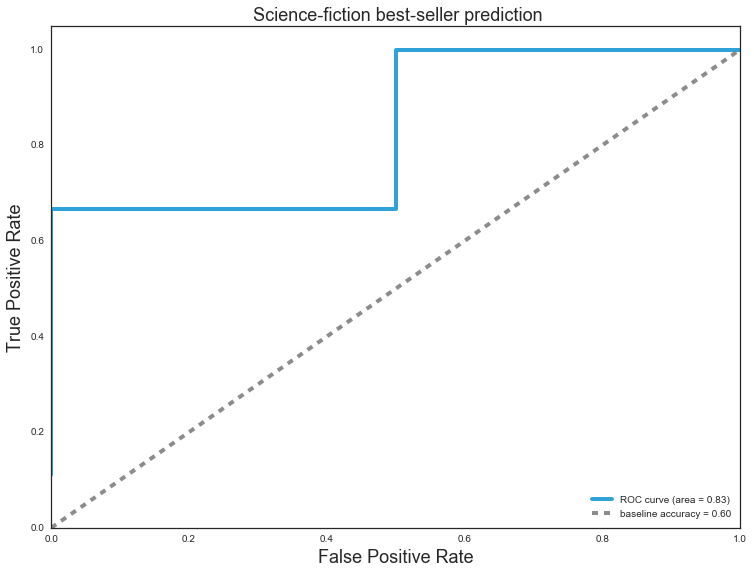

In [65]:
plot_roc_curve(target=y_sf_test, predict_proba=rf_proba_sf[:,1], title='Science-fiction best-seller prediction')

#### Romance

In [66]:
y_rm = rm['best_seller']
X_rm = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]


print y_rm.shape, X_rm.shape

(45,) (45, 54)


In [67]:
X_rm, X_rm_test, y_rm, y_rm_test = train_test_split(X_rm, y_rm, test_size=0.3)

print X_rm.shape, y_rm.shape
print X_rm_test.shape, y_rm_test.shape

(31, 54) (31,)
(14, 54) (14,)


In [73]:
rfc = RandomForestClassifier()
rf_params = {
    'max_features':['log2','sqrt', 2,3,4,5],
    'max_depth':[1,2,3,4],
    'min_samples_leaf':np.linspace(1,20,10),
    'n_estimators':[80]
}

rf_gs_rm = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_model_rm = rf_gs_rm.fit(X_rm, y_rm) 

rf_proba_rm = rf_model_rm.predict_log_proba(X_rm_test)

rfc_best_rm = rf_gs_rm.best_estimator_
print "best estimator", rfc_best_rm
print 
print "best parameters",  rf_gs_rm.best_params_
print 
print "best score", rf_gs_rm.best_score_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  2.5min finished


best estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=7.3333333333333339, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters {'max_features': 'log2', 'n_estimators': 80, 'max_depth': 2, 'min_samples_leaf': 7.3333333333333339}

best score 0.741935483871


In [75]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':X_rm.columns, 
                                   'importance':rfc_best_rm.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(10)

,feature,importance
39,verb.body,0.062500
14,verb_aux,0.062500
12,adj_compare,0.062500
24,adv_compare,0.051399
23,adv,0.050000
25,adv_sup,0.047981
26,adv_part,0.044374
13,adj_sup,0.037500
30,verb_past,0.037500
2,lex_diversity,0.037500


In [77]:
feature_importance.tail(2)

,feature,importance
1,avg_word_len,0.0
0,avg_sent_len,0.0


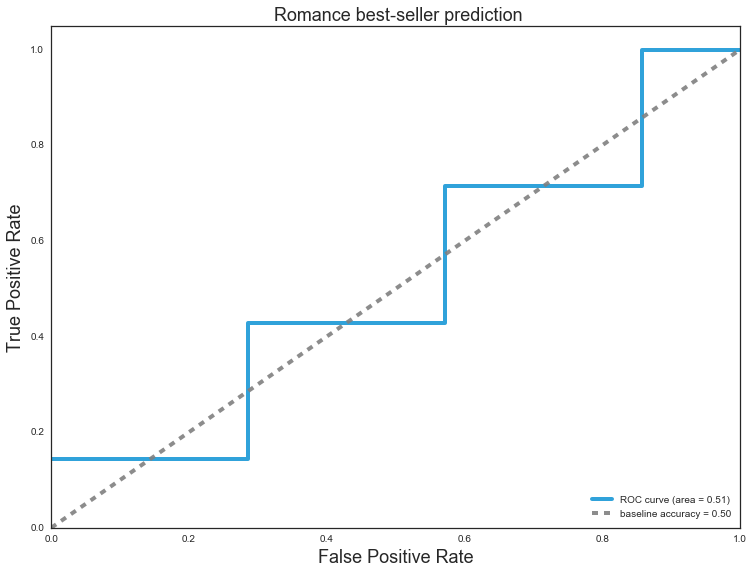

In [79]:
plot_roc_curve(target=y_rm_test, predict_proba=rf_proba_rm[:,1], title='Romance best-seller prediction')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  2.7min finished


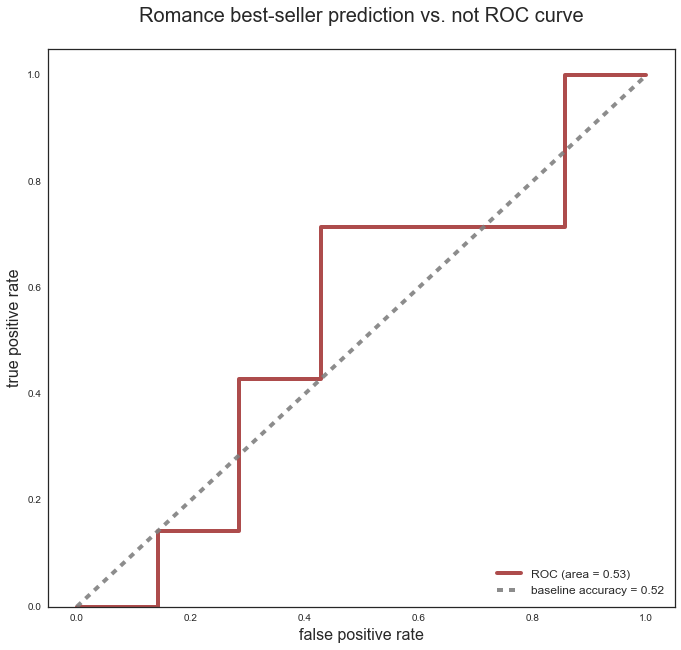

In [86]:
plot_roc(rf_model_rm, X_rm, X_rm_test,y_rm,y_rm_test,'Romance best-seller prediction')

In [64]:
def plot_roc_curve(target=False, predict_proba=False, title='Your prediction'):

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    FPR[1], TPR[1], _ = roc_curve(target,predict_proba)
    ROC_AUC[1] = auc(FPR[1], TPR[1])
    acc_ = np.abs(0.5 - np.mean(target)) + 0.5

    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    #plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(' %s' % title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

In [85]:
def plot_roc(mod, X, X_test,y,y_test, varname):
    mod.fit(X, y)
    y_pp = mod.predict_log_proba(X_test)[:, 1]
    fpr_, tpr_, _ = roc_curve(y_test, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(10,10))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)
    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)
    
    axr.legend(loc="lower right", fontsize=12)
    plt.show()